# Methylation plots

This is a notebook to create plots for chapter 4 & 5.

1. Create dataframe
2. Create plots and run statistical tests

In [ ]:
%matplotlib inline

In [201]:
import pybedtools
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
import os
import pprint
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from seaborn import boxenplot

In [203]:
#First we need to define the base dirs
DIRS = {}
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')

### <span style='color:red'> 10.A Make the dataframe <span/>

In [810]:
# make the dataframes for p and h
h_contig_df = pd.read_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df_h.tsv'),sep='\t')
p_contig_df = pd.read_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df_p.tsv'),sep='\t')

In [777]:
p_contig_df['Gene_type']

0                Other\ngenes
1                Other\ngenes
2        Candidate\neffectors
3                Other\ngenes
4                Other\ngenes
5                Other\ngenes
6                Other\ngenes
7                Other\ngenes
8        Candidate\neffectors
9                Other\ngenes
10                     BUSCOs
11               Other\ngenes
12               Other\ngenes
13               Other\ngenes
14               Other\ngenes
15               Other\ngenes
16               Other\ngenes
17                     BUSCOs
18       Candidate\neffectors
19               Other\ngenes
20               Other\ngenes
21                     BUSCOs
22               Other\ngenes
23               Other\ngenes
24               Other\ngenes
25               Other\ngenes
26               Other\ngenes
27               Other\ngenes
28               Other\ngenes
29               Other\ngenes
                 ...         
19318            Other\ngenes
19319            Other\ngenes
19320     

In [778]:
h_contig_df['Gene_type']

0        Candidate\neffectors
1        Candidate\neffectors
2                Other\ngenes
3                Other\ngenes
4                    TE genes
5                    TE genes
6                Other\ngenes
7                Other\ngenes
8                Other\ngenes
9        Candidate\neffectors
10               Other\ngenes
11                     BUSCOs
12               Other\ngenes
13               Other\ngenes
14               Other\ngenes
15               Other\ngenes
16               Other\ngenes
17               Other\ngenes
18                     BUSCOs
19       Candidate\neffectors
20                   TE genes
21                   TE genes
22               Other\ngenes
23               Other\ngenes
24                   TE genes
25       Candidate\neffectors
26               Other\ngenes
27               Other\ngenes
28                     BUSCOs
29               Other\ngenes
                 ...         
17169            Other\ngenes
17170                  BUSCOs
17171     

In [811]:
print(len(p_contig_df))
print(len(h_contig_df))

19348
17199


#### <span style='color:#a347ff'> 10.A.1 Add columns at the end of the dataframe for the top 500 genes for each methylation type.<span/>

- top 500 5mc gene body
- top 500 5mc upstream
- top 500 5mc downstream
- top 500 5mc both
- top 500 6ma tss
- top 500 6ma pb tss

In [812]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
h_contig_df["Top_500_5mC_gene_body"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_gene_body', ascending=False).iloc[:500].index,"Top_500_5mC_gene_body"] = "Highly methylated"

h_contig_df["Top_500_5mC_upstream"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_upstream', ascending=False).iloc[:500].index,"Top_500_5mC_upstream"] = "Highly methylated"

h_contig_df["Top_500_5mC_downstream"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_downstream', ascending=False).iloc[:500].index,"Top_500_5mC_downstream"] = "Highly methylated"

h_contig_df["Top_500_5mC_both"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_both', ascending=False).iloc[:500].index,"Top_500_5mC_both"] = "Highly methylated"

h_contig_df["Top_500_6mA_tss"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_tss', ascending=False).iloc[:500].index,"Top_500_6mA_tss"] = "Highly methylated"

h_contig_df["Top_500_6mA_tss_pb"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_tss_pb', ascending=False).iloc[:500].index,"Top_500_6mA_tss_pb"] = "Highly methylated"


# do the same for highly expressed genes
h_contig_df["Top_500_UG"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='UG', ascending=False).iloc[:500].index,"Top_500_UG"] = "Highly expressed"

h_contig_df["Low_500_UG"] = "Other"
h_contig_df.loc[h_contig_df.sort_values(by='UG', ascending=True).iloc[:500].index,"Low_500_UG"] = "Lowly expressed"

In [813]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
p_contig_df["Top_500_5mC_gene_body"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_gene_body', ascending=False).iloc[:500].index,"Top_500_5mC_gene_body"] = "Highly methylated"

p_contig_df["Top_500_5mC_upstream"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_upstream', ascending=False).iloc[:500].index,"Top_500_5mC_upstream"] = "Highly methylated"

p_contig_df["Top_500_5mC_downstream"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_downstream', ascending=False).iloc[:500].index,"Top_500_5mC_downstream"] = "Highly methylated"

p_contig_df["Top_500_5mC_both"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_both', ascending=False).iloc[:500].index,"Top_500_5mC_both"] = "Highly methylated"

p_contig_df["Top_500_6mA_tss"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='6mA_tss', ascending=False).iloc[:500].index,"Top_500_6mA_tss"] = "Highly methylated"

p_contig_df["Top_500_6mA_tss_pb"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='6mA_tss_pb', ascending=False).iloc[:500].index,"Top_500_6mA_tss_pb"] = "Highly methylated"

# do the same for highly expressed genes
p_contig_df["Top_500_UG"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='UG', ascending=False).iloc[:500].index,"Top_500_UG"] = "Highly expressed"

p_contig_df["Low_500_UG"] = "Other"
p_contig_df.loc[p_contig_df.sort_values(by='UG', ascending=True).iloc[:500].index,"Low_500_UG"] = "Lowly expressed"

In [814]:
h_contig_df = h_contig_df.replace(to_replace='Highly expressed', value='Highly\nexpressed')
h_contig_df = h_contig_df.replace(to_replace='Lowly expressed', value='Lowly\nexpressed')
h_contig_df = h_contig_df.replace(to_replace='Highly methylated', value='Highly\nmethylated')
h_contig_df = h_contig_df.replace(to_replace='Lowly methylated', value='Lowly\nmethylated')

In [815]:
p_contig_df = p_contig_df.replace(to_replace='Highly expressed', value='Highly\nexpressed')
p_contig_df = p_contig_df.replace(to_replace='Lowly expressed', value='Lowly\nexpressed')
p_contig_df = p_contig_df.replace(to_replace='Highly methylated', value='Highly\nmethylated')
p_contig_df = p_contig_df.replace(to_replace='Lowly methylated', value='Lowly\nmethylated')

#### <span style='color:#a347ff'> 10.A.1 Add columns at the end of the dataframe for log-transformed expression and methylation data.<span/>

In [816]:
#add 0.1 for log transformation
h_contig_df['UG_01'] = h_contig_df['UG'] + 0.1
h_contig_df['HE_01'] = h_contig_df['HE'] + 0.1
h_contig_df['IT6_01'] = h_contig_df['IT6'] + 0.1
h_contig_df['IT9_01'] = h_contig_df['IT9'] + 0.1

p_contig_df['UG_01'] = p_contig_df['UG'] + 0.1
p_contig_df['HE_01'] = p_contig_df['HE'] + 0.1
p_contig_df['IT6_01'] = p_contig_df['IT6'] + 0.1
p_contig_df['IT9_01'] = p_contig_df['IT9'] + 0.1

In [817]:
# can't see the plot, so log transform
#add 0.1 for log transformation
h_contig_df['5mC_gene_body_01'] = h_contig_df['5mC_gene_body'] + 0.1
h_contig_df['5mC_both_01'] = h_contig_df['5mC_both'] + 0.1
h_contig_df['6mA_tss_01'] = h_contig_df['6mA_tss'] + 0.1
h_contig_df['6mA_tss_pb_01'] = h_contig_df['6mA_tss_pb'] + 0.1

p_contig_df['5mC_gene_body_01'] = p_contig_df['5mC_gene_body'] + 0.1
p_contig_df['5mC_both_01'] = p_contig_df['5mC_both'] + 0.1
p_contig_df['6mA_tss_01'] = p_contig_df['6mA_tss'] + 0.1
p_contig_df['6mA_tss_pb_01'] = p_contig_df['6mA_tss_pb'] + 0.1

In [818]:
# save out these dataframes for later
h_contig_df.to_csv(os.path.join(DIRS['FIGURES'], 'expression', 'new_rnaseq_methyl_df_h.tsv'), index=None, header=True, sep='\t')
p_contig_df.to_csv(os.path.join(DIRS['FIGURES'], 'expression', 'new_rnaseq_methyl_df_p.tsv'), index=None, header=True, sep='\t')

### <span style='color:red'> 10.B Analysis on highly methylated genes <span/>

#### <span style='color:#a347ff'> 10.B.1 Comparing highly expresssed genes with highly methylated genes with permutations.<span/>

- permutations
- expected value: number of overlapping genes between two groups of 500 randomly chosen sites
- observed value1: number of overlapping genes between highly methylated and highly expressed
- observed value2: number of overlapping genes between highly methylated and lowly expressed

In [317]:
#permutation function for 5mC
def permutation_5mC(df, col1, tf1, col2, tf2, heading, fn):
    """This function runs permutations on the overlap between the top/bottom 500 methylation and expressed genes, and compares the observed to this distributino to get a p-value and generate a violin plot."""
    # make lists of 500 genes from methylation data and expression data
    methyl_list = h_contig_df.sort_values(by=col1, ascending=tf1).iloc[:500,0]
    exp_list = h_contig_df.sort_values(by=col2, ascending=tf2).iloc[:500,0]
    
    # calculate the overlap between lists
    overlap = len(np.intersect1d(methyl_list, exp_list))
    
    # run permutations 10,000 times to get expected distribution of overlaps
    rand_500_overlap = []
    for x in range(0,10000):
        random_array_0 = np.random.choice(h_contig_df.shape[0], 500, replace=False)
        random_array_1 = np.random.choice(h_contig_df.shape[0], 500, replace=False)
        rand_500_overlap.append(len(np.intersect1d(random_array_0, random_array_1)))
    
    #calculate p value
    count = 0
    for i in rand_500_overlap:
        if i > overlap:
            count += 1
    p = count/10000
    fisher_dict[col1] = overlap, p
    
    #plot it
    f, ax = plt.subplots(figsize=(4, 7))
    plt.style.use('fast')
    sns.violinplot(y=rand_500_overlap, color='c')
    plt.axhline(y=overlap, color='r', linestyle='-')
    plt.title(heading, fontsize=16)
    plt.ylabel('Number of overlapping genes', fontsize=16)
    plt.xlabel('p=' + str(p), fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    outfn = col1 + '_' + fn + '.png'
    plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', outfn), bbox_inches='tight')

In [231]:
#rename this to perm dict at the end :)
def save_fisher_dict(wdict, genome):
    df = pd.DataFrame.from_dict(wdict, orient='index')
    df.rename(columns={0: 'Fisher exact test statistic', 1: 'p-value'}, inplace=True)
    out_fn = os.path.join(DIRS['FIGURES'], 'expression', ('fisher_table_%s.tsv' % genome))
    df.to_csv(out_fn, header=True, sep = '\t')

In [214]:
fisher_dict = {}

#### <span style='color:#0099ff'> 10.B.1.i Permutations on h contig.<span/>

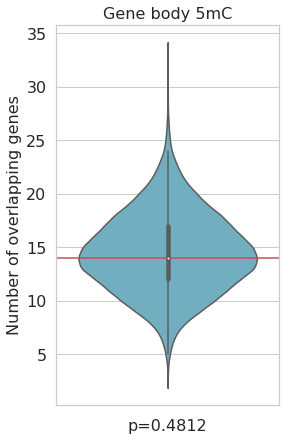

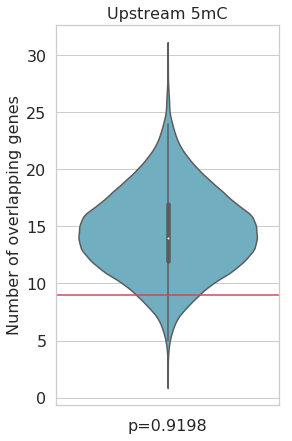

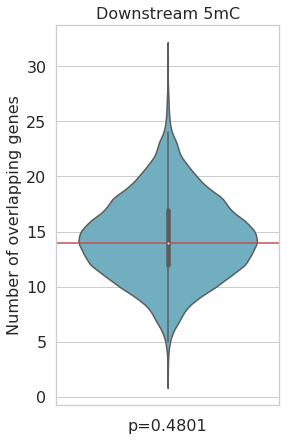

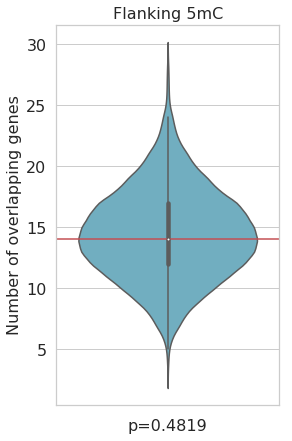

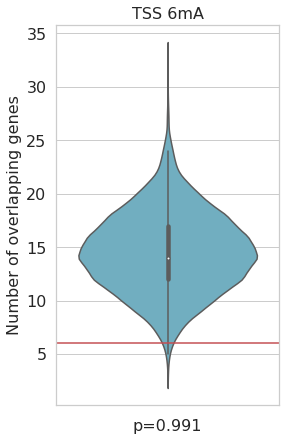

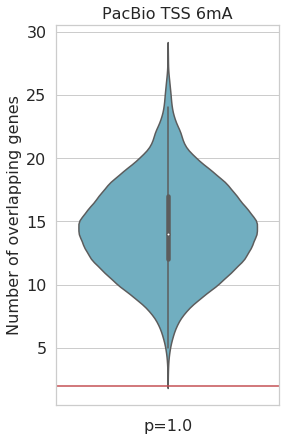

In [740]:
# high expression
fisher_dict = {}
permutation_5mC(h_contig_df, "5mC_gene_body", False, 'UG', False, 'Gene body 5mC', 'high_expression_h')
permutation_5mC(h_contig_df, "5mC_upstream", False, 'UG', False, 'Upstream 5mC', 'high_expression_h')
permutation_5mC(h_contig_df, "5mC_downstream", False, 'UG', False, 'Downstream 5mC', 'high_expression_h')
permutation_5mC(h_contig_df, "5mC_both", False, 'UG', False, 'Flanking 5mC', 'high_expression_h')
permutation_5mC(h_contig_df, "6mA_tss", False, 'UG', False, 'TSS 6mA', 'high_expression_h')
permutation_5mC(h_contig_df, "6mA_tss_pb", False, 'UG', False, 'PacBio TSS 6mA', 'high_expression_h')
save_fisher_dict(fisher_dict, 'high_expression_h')

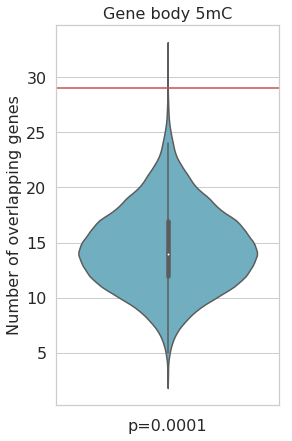

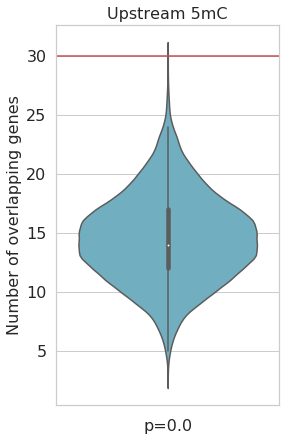

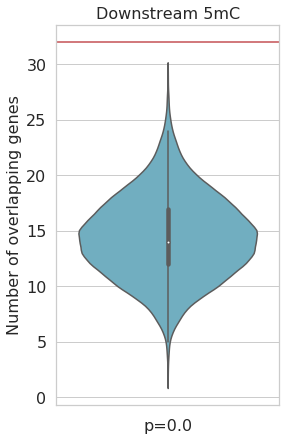

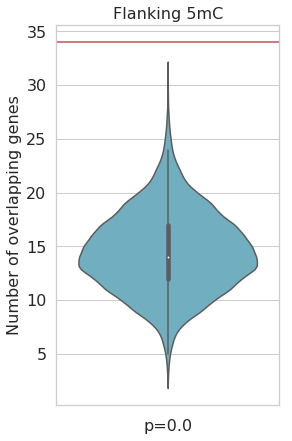

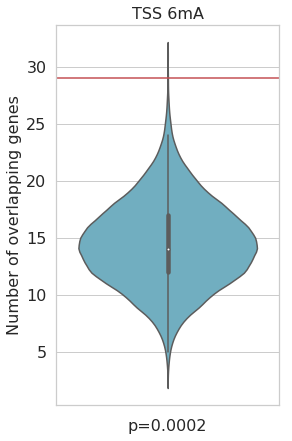

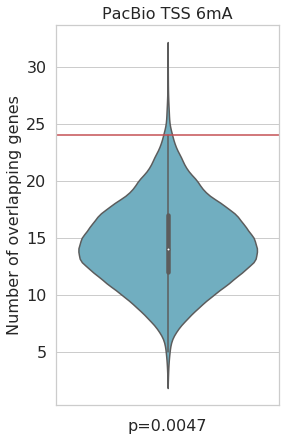

In [741]:
# low expression
fisher_dict  = {}
permutation_5mC(h_contig_df, "5mC_gene_body", False, 'UG', True, 'Gene body 5mC', 'low_expression_h')
permutation_5mC(h_contig_df, "5mC_upstream", False, 'UG', True, 'Upstream 5mC', 'low_expression_h')
permutation_5mC(h_contig_df, "5mC_downstream", False, 'UG', True, 'Downstream 5mC', 'low_expression_h')
permutation_5mC(h_contig_df, "5mC_both", False, 'UG', True, 'Flanking 5mC', 'low_expression_h')
permutation_5mC(h_contig_df, "6mA_tss", False, 'UG', True, 'TSS 6mA', 'low_expression_h')
permutation_5mC(h_contig_df, "6mA_tss_pb", False, 'UG', True, 'PacBio TSS 6mA', 'low_expression_h')
save_fisher_dict(fisher_dict, 'low_expression_h')

#### <span style='color:#0099ff'> 10.B.1.ii Permutations on p contig.<span/>

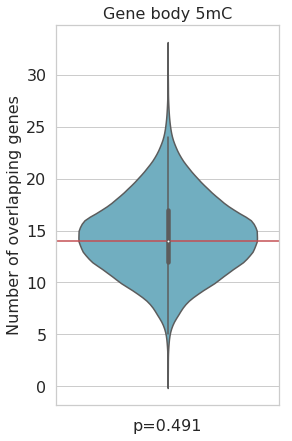

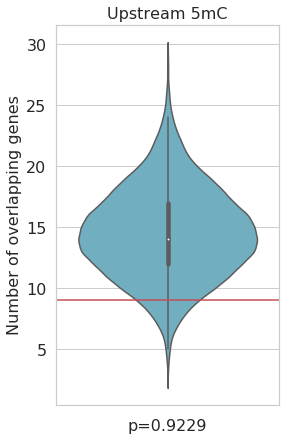

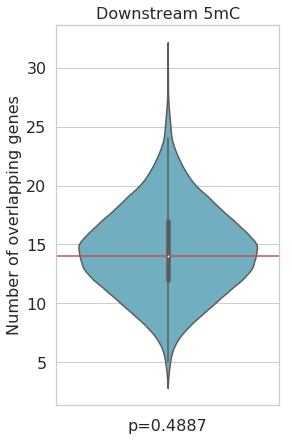

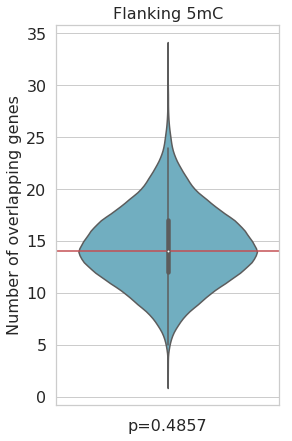

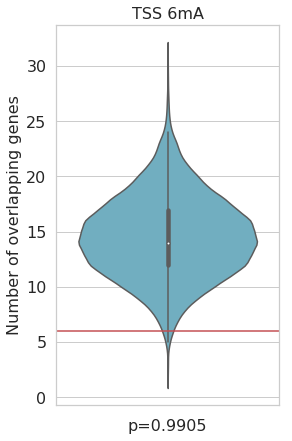

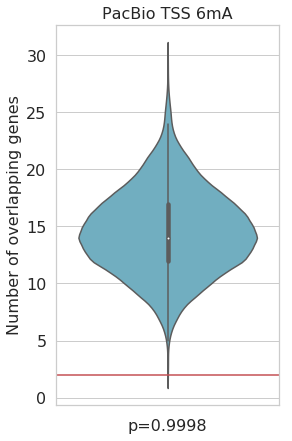

In [742]:
# high expression
fisher_dict = {}
permutation_5mC(p_contig_df, "5mC_gene_body", False, 'UG', False, 'Gene body 5mC', 'high_expression_p')
permutation_5mC(p_contig_df, "5mC_upstream", False, 'UG', False, 'Upstream 5mC', 'high_expression_p')
permutation_5mC(p_contig_df, "5mC_downstream", False, 'UG', False, 'Downstream 5mC', 'high_expression_p')
permutation_5mC(p_contig_df, "5mC_both", False, 'UG', False, 'Flanking 5mC', 'high_expression_p')
permutation_5mC(p_contig_df, "6mA_tss", False, 'UG', False, 'TSS 6mA', 'high_expression_p')
permutation_5mC(p_contig_df, "6mA_tss_pb", False, 'UG', False, 'PacBio TSS 6mA', 'high_expression_p')
save_fisher_dict(fisher_dict, 'high_expression_p')

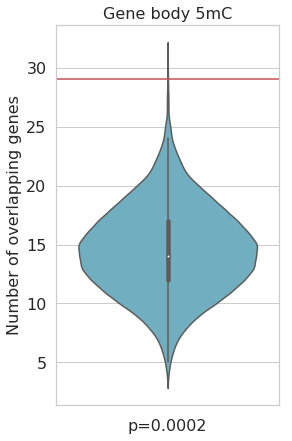

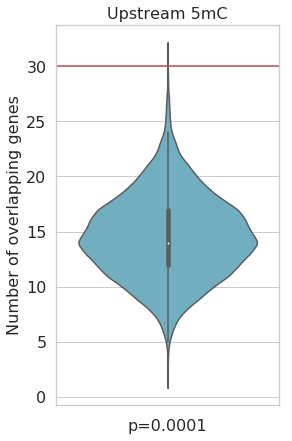

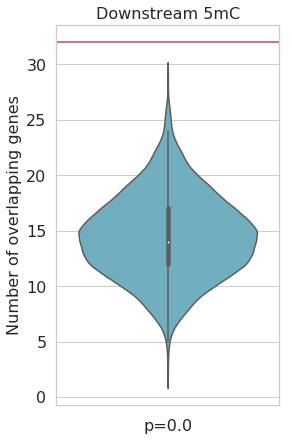

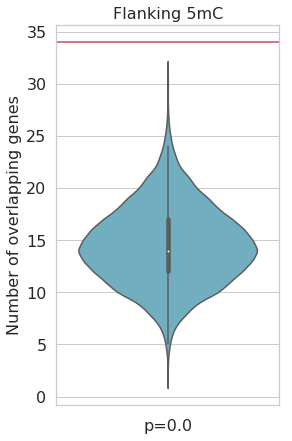

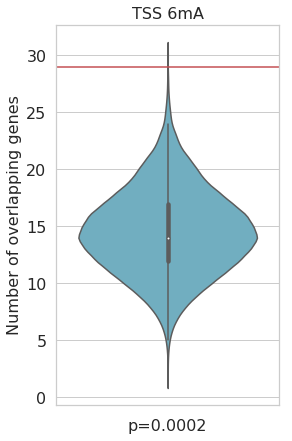

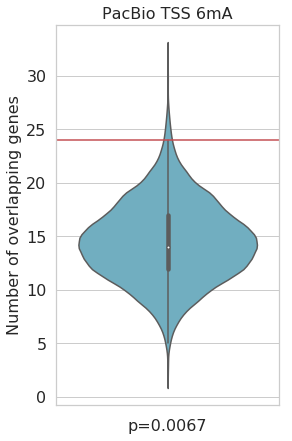

In [743]:
# low expression
fisher_dict = {}
permutation_5mC(p_contig_df, "5mC_gene_body", False, 'UG', True, 'Gene body 5mC', 'low_expression_p')
permutation_5mC(p_contig_df, "5mC_upstream", False, 'UG', True, 'Upstream 5mC', 'low_expression_p')
permutation_5mC(p_contig_df, "5mC_downstream", False, 'UG', True, 'Downstream 5mC', 'low_expression_p')
permutation_5mC(p_contig_df, "5mC_both", False, 'UG', True, 'Flanking 5mC', 'low_expression_p')
permutation_5mC(p_contig_df, "6mA_tss", False, 'UG', True, 'TSS 6mA', 'low_expression_p')
permutation_5mC(p_contig_df, "6mA_tss_pb", False, 'UG', True, 'PacBio TSS 6mA', 'low_expression_p')
save_fisher_dict(fisher_dict, 'low_expression_p')

#### <span style='color:#a347ff'> 10.B.2 Make plots for top 500 methylated genes.<span/>

In [223]:
# for the columns in graphs
order_1 = ['Highly\nmethylated', 'Other']

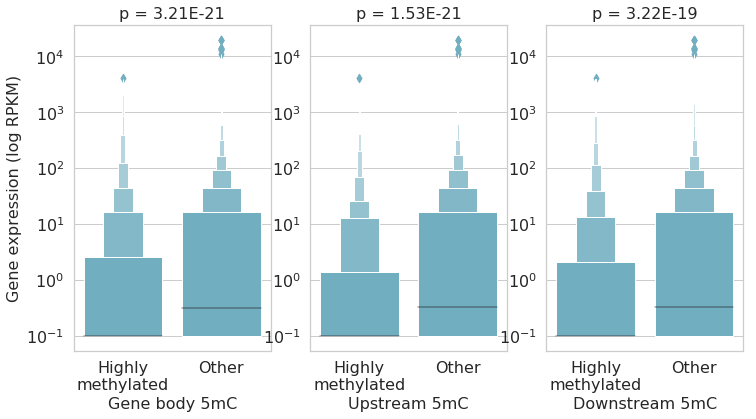

In [481]:
#make the actual graph for h contig
f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')


sns.boxenplot(y='UG_01', x='Top_500_5mC_gene_body', data=h_contig_df, order=order_1, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_xlabel('Gene body 5mC', fontsize=16)
ax[0].set_title('p = 3.21E-21', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

sns.boxenplot(y='UG_01', x='Top_500_5mC_upstream', data=h_contig_df, order=order_1, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('Upstream 5mC', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 1.53E-21', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_5mC_downstream', data=h_contig_df, order=order_1, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('Downstream 5mC', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 3.22E-19', fontsize=16)


plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'top_500_all_h.png'), bbox_inches='tight')

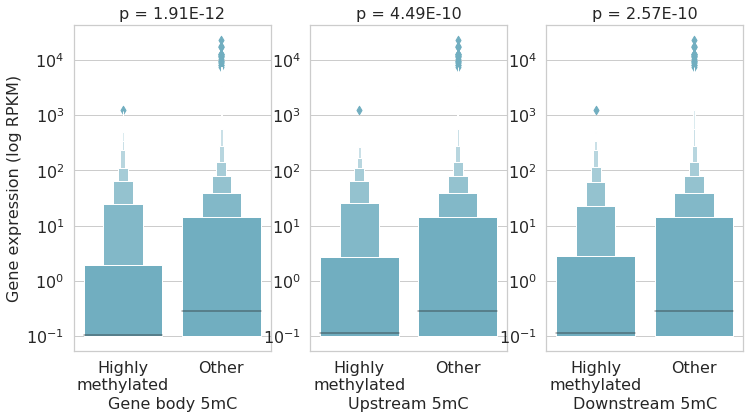

In [482]:
f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')


sns.boxenplot(y='UG_01', x='Top_500_5mC_gene_body', data=p_contig_df, order=order_1, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_xlabel('Gene body 5mC', fontsize=16)
ax[0].set_title('p = 1.91E-12', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

sns.boxenplot(y='UG_01', x='Top_500_5mC_upstream', data=p_contig_df, order=order_1, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('Upstream 5mC', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 4.49E-10', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_5mC_downstream', data=p_contig_df, order=order_1, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('Downstream 5mC', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 2.57E-10', fontsize=16)


plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'top_500_all_p.png'), bbox_inches='tight')

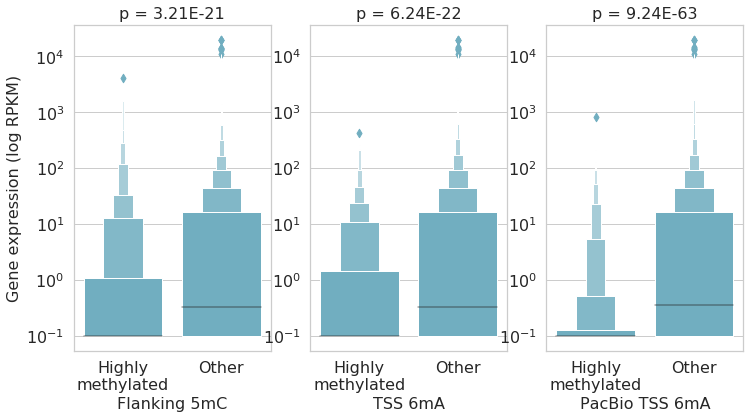

In [758]:
#make the actual graph for p contig

f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')

sns.boxenplot(y='UG_01', x='Top_500_5mC_both', data=h_contig_df, order=order_1, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_xlabel('Flanking 5mC', fontsize=16)
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_title('p = 3.21E-21', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_6mA_tss', data=h_contig_df, order=order_1, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('TSS 6mA', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 6.24E-22', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_6mA_tss_pb', data=h_contig_df, order=order_1, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('PacBio TSS 6mA', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 9.24E-63', fontsize=16)

plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'top_500_all2_h.png'), bbox_inches='tight')


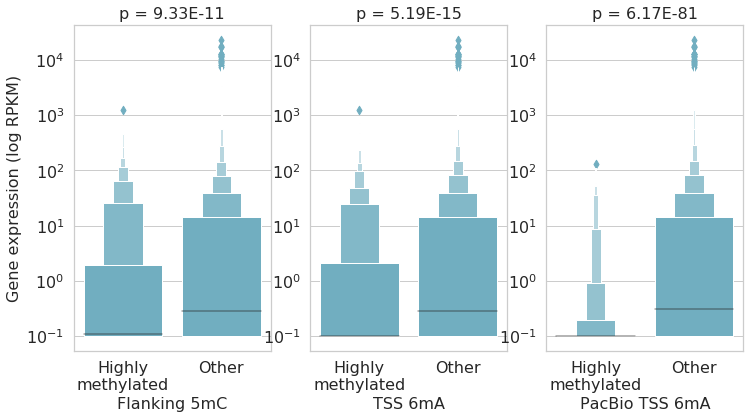

In [755]:
f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')

sns.boxenplot(y='UG_01', x='Top_500_5mC_both', data=p_contig_df, order=order_1, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_xlabel('Flanking 5mC', fontsize=16)
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_title('p = 9.33E-11', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_6mA_tss', data=p_contig_df, order=order_1, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('TSS 6mA', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 5.19E-15', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_500_6mA_tss_pb', data=p_contig_df, order=order_1, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('PacBio TSS 6mA', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 6.17E-81', fontsize=16)

plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'top_500_all2_p.png'), bbox_inches='tight')

#### <span style='color:#a347ff'> 10.B.C Runn Mann-Whitney U test for top 500 methylated genes.<span/>

In [276]:
# run mann whitney U for these top500 data to put in the plots
# function to make graph and save out dictionary of mann whitney u
def top500_mwu(df, col, mod):
    stat, p = mannwhitneyu(df[df[col] == 'Other']['UG'],df[df[col] == 'Highly\nmethylated']['UG'] )
    mwu_dict[mod] = stat, p

In [257]:
#save it out
def save_dict_to_tsv(wdict, header, filename):
    df = pd.DataFrame.from_dict(wdict, orient='index')
    df.rename(columns={0: header, 1: 'p-value'}, inplace=True)
    out_fn = os.path.join(DIRS['FIGURES'], 'expression', filename)
    df.to_csv(out_fn, header=True, sep = '\t')

In [748]:
# run the plots for each type: 5mc up, down, both, gene body, tss, pb
top500_mwu(p_contig_df, 'Top_500_5mC_gene_body', 'Gene body 5mC')
top500_mwu(p_contig_df, 'Top_500_5mC_upstream', 'Upstream 5mC')
top500_mwu(p_contig_df, 'Top_500_5mC_downstream', 'Downstream 5mC')
top500_mwu(p_contig_df, 'Top_500_5mC_both', 'Both upstream and downstream 5mC')
top500_mwu(p_contig_df, 'Top_500_6mA_tss', 'TSS 6mA')
top500_mwu(p_contig_df, 'Top_500_6mA_tss_pb', 'PacBio TSS 6mA')

save_dict_to_tsv(mwu_dict, 'Mann Whitney U statistic', 'top500_mwu_table_p.tsv')

In [750]:
# run the plots for each type: 5mc up, down, both, gene body, tss, pb
top500_mwu(h_contig_df, 'Top_500_5mC_gene_body', 'Gene body 5mC')
top500_mwu(h_contig_df, 'Top_500_5mC_upstream', 'Upstream 5mC')
top500_mwu(h_contig_df, 'Top_500_5mC_downstream', 'Downstream 5mC')
top500_mwu(h_contig_df, 'Top_500_5mC_both', 'Both upstream and downstream 5mC')
top500_mwu(h_contig_df, 'Top_500_6mA_tss', 'TSS 6mA')
top500_mwu(h_contig_df, 'Top_500_6mA_tss_pb', 'PacBio TSS 6mA')

save_dict_to_tsv(mwu_dict, 'Mann Whitney U statistic', 'top500_mwu_table_h.tsv')

In [749]:
#p contig
mwu_dict

{'Both upstream and downstream 5mC': (3933977.5, 4.996046121353421e-11),
 'Downstream 5mC': (3964279.0, 2.5629872009684715e-10),
 'Gene body 5mC': (3876605.0, 1.906264233338097e-12),
 'PacBio TSS 6mA': (2424157.0, 6.167897681101841e-81),
 'TSS 6mA': (3781498.5, 5.190274197624713e-15),
 'Upstream 5mC': (3974941.0, 4.4895707401749324e-10)}

In [751]:
#h contig
mwu_dict

{'Both upstream and downstream 5mC': (3172806.5, 3.213836087680504e-21),
 'Downstream 5mC': (3226053.0, 3.2215494170472786e-19),
 'Gene body 5mC': (3317799.0, 5.078114967941932e-16),
 'PacBio TSS 6mA': (2393619.5, 9.240810593276643e-63),
 'TSS 6mA': (3154522.0, 6.240861258704862e-22),
 'Upstream 5mC': (3164498.5, 1.5316926596053925e-21)}

### <span style='color:red'> 10.C Analysis gene types <span/>

#### <span style='color:#a347ff'> 10.C.1 Run Mann-Whitney U test with Bonferroni correction for multiple testing for gene types. <span/>

In [118]:
# get the sample size for each gene type
print(len(p_contig_df[p_contig_df['Gene_type'] == 'Other genes']))
print(len(p_contig_df[p_contig_df['Gene_type'] == 'Effector']))
print(len(p_contig_df[p_contig_df['Gene_type'] == 'BUSCO']))
print(len(p_contig_df[p_contig_df['Gene_type'] == 'TE gene']))

13415
1069
1444
3420


In [119]:
print(len(h_contig_df[h_contig_df['Gene_type'] == 'Other genes']))
print(len(h_contig_df[h_contig_df['Gene_type'] == 'Effector']))
print(len(h_contig_df[h_contig_df['Gene_type'] == 'BUSCO']))
print(len(h_contig_df[h_contig_df['Gene_type'] == 'TE gene']))

12059
969
1293
2878


In [625]:
def multiple(df, col, genome):
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'Other\ngenes'][col], df[df['Gene_type'] == 'Candidate\neffectors'][col])
    multiple_mwu_dict['Other genes, Candidate effectors'] = stat, p
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'Other\ngenes'][col], df[df['Gene_type'] == 'BUSCOs'][col])
    multiple_mwu_dict['Other genes, BUSCOs'] = stat, p
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'Other\ngenes'][col], df[df['Gene_type'] == 'TE genes'][col])
    multiple_mwu_dict['Other genes, TE genes'] = stat, p
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'Candidate\neffectors'][col], df[df['Gene_type'] == 'BUSCOs'][col])
    multiple_mwu_dict['Candidate effectors, BUSCOs'] = stat, p
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'Candidate\neffectors'][col], df[df['Gene_type'] == 'TE genes'][col])
    multiple_mwu_dict['Candidate effectors, TE genes'] = stat, p
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'BUSCOs'][col], df[df['Gene_type'] == 'TE genes'][col])
    multiple_mwu_dict['BUSCOs, TE genes'] = stat, p
    p_list = []
    k_list = []
    p2 = []
    for key, value in multiple_mwu_dict.items():
        k_list.append(key)
        p_list.append(value[1])
    result, p, a, b = multipletests(p_list, alpha=0.05, method='bonferroni')
    for i in p:
        n = ("{0:.2E}".format(i))
        p2.append(n)
    l = ['Gene types compared', 'Corrected p-value (Bonferroni)']
    d = dict(zip(l,[k_list,p2]))
    df = pd.DataFrame.from_dict(d)
    out_fn = os.path.join(DIRS['FIGURES'], 'expression', ('bonferroni_table_%s_%s.tsv' % (col,genome)))
    df.to_csv(out_fn, header=True, index=None, sep = '\t')

In [630]:
multiple(h_contig_df, '6mA_tss', 'h')
multiple(h_contig_df, '5mC_gene_body', 'h')
multiple(h_contig_df, '5mC_upstream', 'h')
multiple(h_contig_df, '5mC_downstream', 'h')
multiple(h_contig_df, '5mC_both', 'h')
multiple(h_contig_df, 'UG', 'h')
multiple(h_contig_df, 'HE', 'h')
multiple(h_contig_df, 'IT6', 'h')
multiple(h_contig_df, 'IT9', 'h')

In [653]:
multiple(p_contig_df, '6mA_tss', 'p')
multiple(p_contig_df, '5mC_gene_body', 'p')
multiple(p_contig_df, '5mC_upstream', 'p')
multiple(p_contig_df, '5mC_downstream', 'p')
multiple(p_contig_df, '5mC_both', 'p')
multiple(p_contig_df, 'UG', 'p')
multiple(p_contig_df, 'HE', 'p')
multiple(p_contig_df, 'IT6', 'p')
multiple(p_contig_df, 'IT9', 'p')

In [759]:
multiple(h_contig_df, '6mA_tss_pb', 'h')
multiple(p_contig_df, '6mA_tss_pb', 'p')

#### <span style='color:#a347ff'> 10.C.2 Run Kruskal-Wallis test for gene types. <span/>

In [663]:
# write kruskal function
def kwh(df, col):
    stat, p = kruskal(df[df['Gene_type'] == 'Other\ngenes'][col], \
                           df[df['Gene_type'] == 'Candidate\neffectors'][col], \
                           df[df['Gene_type'] == 'BUSCOs'][col], \
                           df[df['Gene_type'] == 'TE genes'][col])
    kwh_dict[col] = stat, p

In [ ]:
kwh_dict = {}

In [760]:
kwh(h_contig_df, 'UG')
kwh(h_contig_df, 'HE')
kwh(h_contig_df, 'IT6')
kwh(h_contig_df, 'IT9')
kwh(h_contig_df, '5mC_gene_body')
kwh(h_contig_df, '5mC_upstream')
kwh(h_contig_df, '5mC_downstream')
kwh(h_contig_df, '5mC_both')
kwh(h_contig_df, '6mA_tss')
kwh(h_contig_df, '6mA_tss_pb')

save_dict_to_tsv(kwh_dict, 'Kruskal-Wallis H statistic', 'gene_type_kwh_table_h.tsv')

In [761]:
#h contig
kwh_dict

{'5mC_both': (1148.7954580788257, 9.43354287868527e-249),
 '5mC_downstream': (935.1686384549109, 2.0823753933418167e-202),
 '5mC_gene_body': (1318.0805486761435, 1.7566516822413597e-285),
 '5mC_upstream': (1035.809840552702, 3.067253889729898e-224),
 '6mA_tss': (230.37849253404957, 1.1454602179719414e-49),
 '6mA_tss_pb': (775.6970810252919, 8.069822437831738e-168),
 'HE': (3084.582674544173, 0.0),
 'IT6': (3545.720103343584, 0.0),
 'IT9': (3629.480946350351, 0.0),
 'UG': (3240.317145668025, 0.0)}

In [762]:
kwh(p_contig_df, 'UG')
kwh(p_contig_df, 'HE')
kwh(p_contig_df, 'IT6')
kwh(p_contig_df, 'IT9')
kwh(p_contig_df, '5mC_gene_body')
kwh(p_contig_df, '5mC_upstream')
kwh(p_contig_df, '5mC_downstream')
kwh(p_contig_df, '5mC_both')
kwh(p_contig_df, '6mA_tss')
kwh(p_contig_df, '6mA_tss_pb')

save_dict_to_tsv(kwh_dict, 'Kruskal-Wallis H statistic', 'gene_type_kwh_table_p.tsv')

In [763]:
#p contig
kwh_dict

{'5mC_both': (1741.2350075856095, 0.0),
 '5mC_downstream': (1384.7778673808173, 5.919024900887527e-300),
 '5mC_gene_body': (1973.14085949951, 0.0),
 '5mC_upstream': (1584.9264563447066, 0.0),
 '6mA_tss': (383.63609696187956, 7.753672680535324e-83),
 '6mA_tss_pb': (810.0033806315399, 2.9290000965848454e-175),
 'HE': (3833.6004340623467, 0.0),
 'IT6': (4245.728530775538, 0.0),
 'IT9': (4468.831496727713, 0.0),
 'UG': (3904.6421931306895, 0.0)}

#### <span style='color:#a347ff'> 10.C.3 Plot gene types. <span/>

In [764]:
# run this separately depending on kwh value (0.00 or non-zero)
def genetypelog_plot(df, col, mod, genome):    
    f, ax = plt.subplots(figsize=(6, 5))
    ax.set_yscale("log")
    sns.boxenplot(y=col, x='Gene_type', color='c', order=['Candidate\neffectors', 'BUSCOs', 'TE genes', 'Other\ngenes'], data=df)
    plt.ylabel(mod, fontsize=16)
    plt.xlabel('Gene type', fontsize=16)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    heading = "Kruskal-Wallis, p = " + ("{0:.2E}".format(kwh_dict[col[:-3]][1])) #for non-zero p-value
    #heading = "Kruskal-Wallis, p = " + ("{0:.2f}".format(kwh_dict[col[:-3]][1])) #for p=0.00
    plt.title(heading, fontsize=16)
    outfn = 'gene_types_' + col + genome +'.png'
    outfn = os.path.join(DIRS['FIGURES'], 'expression', outfn)
    plt.savefig(outfn, bbox_inches='tight')  

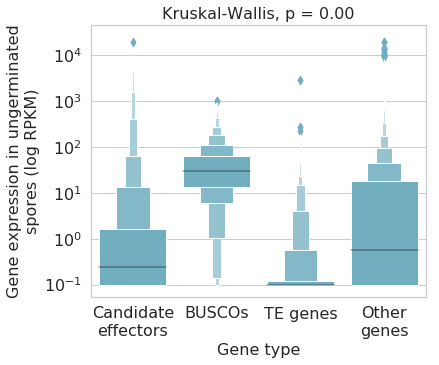

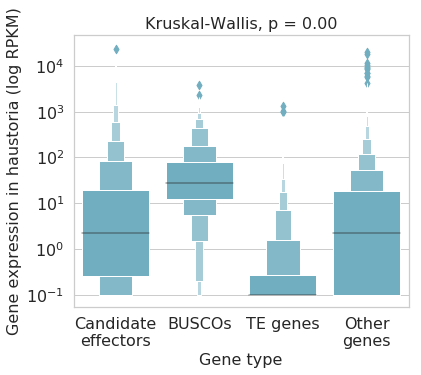

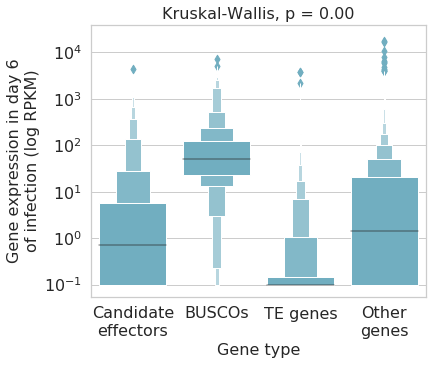

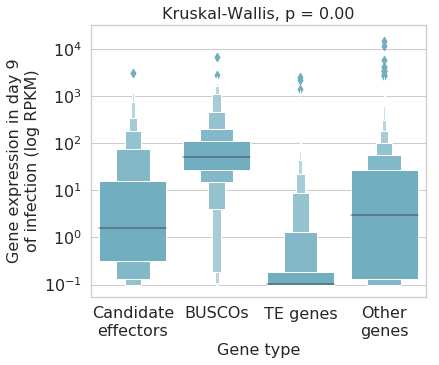

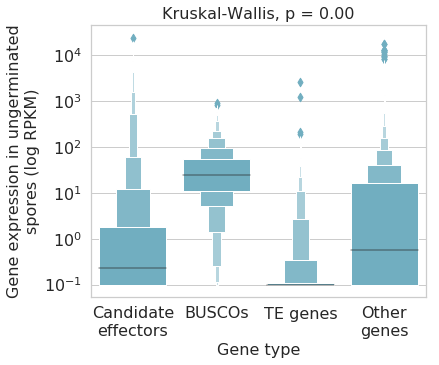

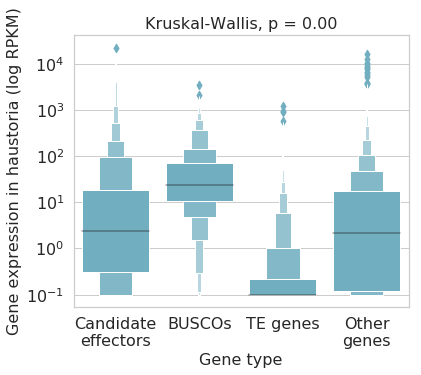

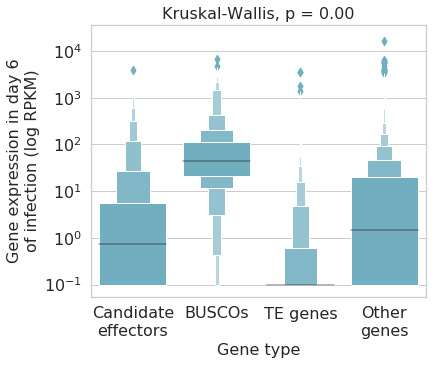

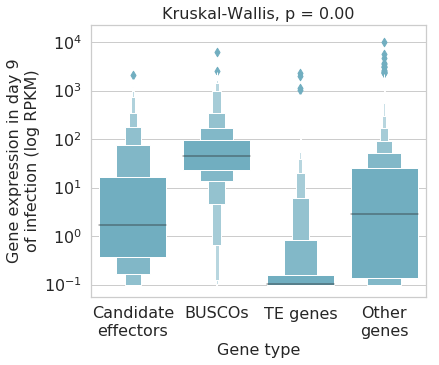

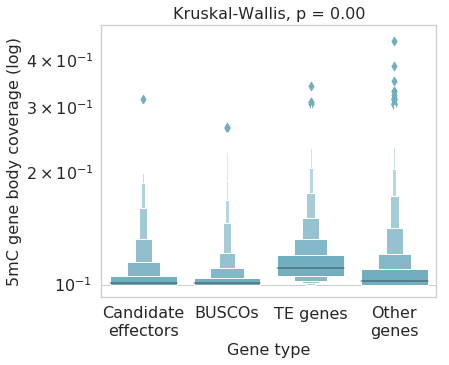

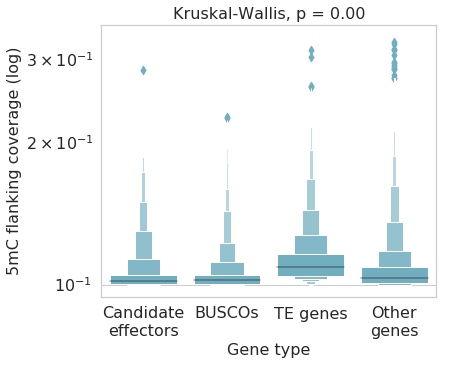

In [705]:
# plot the zeroes

# plot the expression in ungerminated spores
genetypelog_plot(h_contig_df, 'UG_01', 'Gene expression in ungerminated\nspores (log RPKM)', '_h')
genetypelog_plot(h_contig_df, 'HE_01', 'Gene expression in haustoria (log RPKM)', '_h')
genetypelog_plot(h_contig_df, 'IT6_01', 'Gene expression in day 6\nof infection (log RPKM)', '_h')
genetypelog_plot(h_contig_df, 'IT9_01', 'Gene expression in day 9\nof infection (log RPKM)', '_h')

genetypelog_plot(p_contig_df, 'UG_01', 'Gene expression in ungerminated\nspores (log RPKM)', '_p')
genetypelog_plot(p_contig_df, 'HE_01', 'Gene expression in haustoria (log RPKM)', '_p')
genetypelog_plot(p_contig_df, 'IT6_01', 'Gene expression in day 6\nof infection (log RPKM)', '_p')
genetypelog_plot(p_contig_df, 'IT9_01', 'Gene expression in day 9\nof infection (log RPKM)', '_p')

# plot methylated regions
genetypelog_plot(p_contig_df, '5mC_gene_body_01', '5mC gene body coverage (log)', '_p')
genetypelog_plot(p_contig_df, '5mC_both_01', '5mC flanking coverage (log)', '_p')

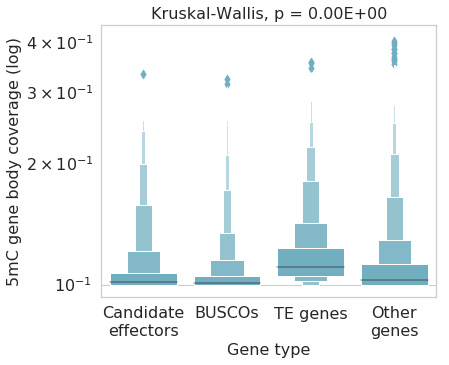

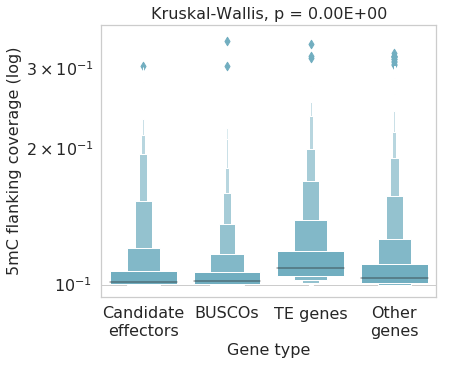

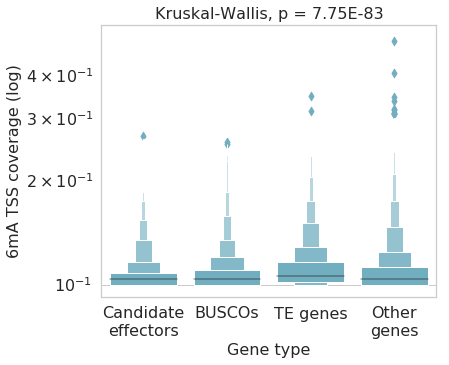

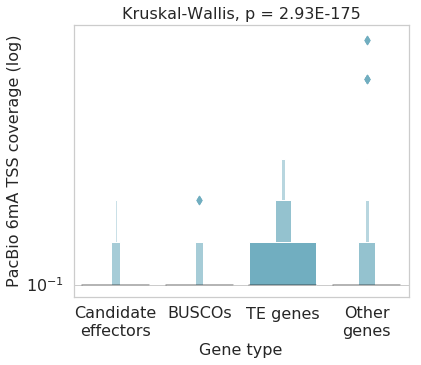

In [765]:
# plot non-zero values

# plot methylated regions
genetypelog_plot(h_contig_df, '5mC_gene_body_01', '5mC gene body coverage (log)', '_h')
genetypelog_plot(h_contig_df, '5mC_both_01', '5mC flanking coverage (log)', '_h')
genetypelog_plot(h_contig_df, '6mA_tss_01', '6mA TSS coverage (log)', '_h')
genetypelog_plot(h_contig_df, '6mA_tss_pb_01', 'PacBio 6mA TSS coverage (log)', '_h')

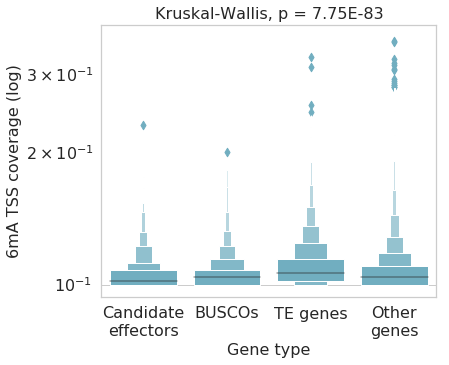

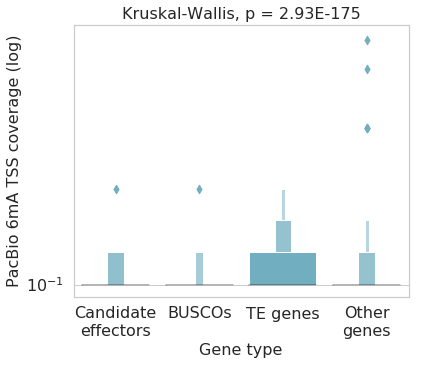

In [766]:
genetypelog_plot(p_contig_df, '6mA_tss_01', '6mA TSS coverage (log)', '_p')
genetypelog_plot(p_contig_df, '6mA_tss_pb_01', 'PacBio 6mA TSS coverage (log)', '_p')

#### <span style='color:#a347ff'> 10.C.4 Test expression difference in TE genes between UG and HE. <span/>

In [714]:
te_gene_mwu_dict = {}

In [718]:
#compare TE gene expression in UG spores to haustoria
def te_gene(df, key):
    stat, p = mannwhitneyu(df[df['Gene_type'] == 'TE genes']['UG'], df[df['Gene_type'] == 'TE genes']['HE'])
    te_gene_mwu_dict[key] = stat, p

In [719]:
te_gene(p_contig_df, 'p')
te_gene(h_contig_df, 'h')

In [720]:
te_gene_mwu_dict

{'h': (3552200.5, 1.0193385507962032e-27),
 'p': (5088739.0, 1.5689999147765816e-28)}

Statistically significant difference between UG and HE means TE expression is higher in Haustoria, meaning they may be important for Haustoria.

### <span style='color:red'> 10.D Analysis on genes hear highly methylated TE. <span/>

#### <span style='color:#a347ff'> 10.D.A Run Mann-Whitney U test on expression difference in genes near methylated TE. <span/>

In [821]:
def gene_te_mwu(df, col, mod):
    stat, p = mannwhitneyu(df[df[col] == 'Other']['UG'],df[df[col] == 'Methylated\nTE adjacent']['UG'] )
    mwu_dict[mod] = stat, p

In [827]:
#run on h contig
mwu_dict = {}
gene_te_mwu(h_contig_df, 'Top_5mC_Gene_TE', '5mC')
gene_te_mwu(h_contig_df, 'Top_6mA_Gene_TE', '6mA')
gene_te_mwu(h_contig_df, 'Top_6mA_pb_Gene_TE', 'PacBio 6mA')

In [828]:
mwu_dict

{'5mC': (745778.5, 0.00486510217242122),
 '6mA': (826233.5, 2.6807553400149723e-05),
 'PacBio 6mA': (1031534.5, 0.031704005910323595)}

In [829]:
mwu_dict = {}
gene_te_mwu(p_contig_df, 'Top_5mC_Gene_TE', '5mC')
gene_te_mwu(p_contig_df, 'Top_6mA_Gene_TE', '6mA')
gene_te_mwu(p_contig_df, 'Top_6mA_pb_Gene_TE', 'PacBio 6mA')

In [830]:
mwu_dict

{'5mC': (1096816.5, 0.030605937032225555),
 '6mA': (1106190.0, 0.0007866825402775909),
 'PacBio 6mA': (1277569.0, 0.14860918801423245)}

#### <span style='color:#a347ff'> 10.D.B Plot expression difference in genes near methylated TE. <span/>

In [802]:
order_2 = ['Methylated\nTE adjacent', 'Other']

In [803]:
h_contig_df.columns

Index(['name', '5mC_gene_body', '6mA_gene_body', '5mC_gene_body_rand',
       '6mA_gene_body_rand', '5mC_upstream', '6mA_upstream',
       '5mC_upstream_rand', '6mA_upstream_rand', '5mC_downstream',
       '6mA_downstream', '5mC_downstream_rand', '6mA_downstream_rand',
       '6mA_tss', '6mA_tss_rand', '6mA_tss_pb', '6mA_tss_pb_rand', '5mC_both',
       '6mA_both', '5mC_both_rand', '6mA_both_rand', 'Gene_type', 'GS', 'HE',
       'IT0', 'IT6', 'IT9', 'UG', 'Top_5mC_Gene_TE', 'Top_6mA_Gene_TE',
       'Top_6mA_pb_Gene_TE', 'Low_5mC_Gene_TE', 'Low_6mA_Gene_TE',
       'Low_6mA_pb_Gene_TE', 'Top_500_5mC_gene_body', 'Top_500_5mC_upstream',
       'Top_500_5mC_downstream', 'Top_500_5mC_both', 'Top_500_6mA_tss',
       'Top_500_6mA_tss_pb', 'Top_500_UG', 'Low_500_UG'],
      dtype='object')

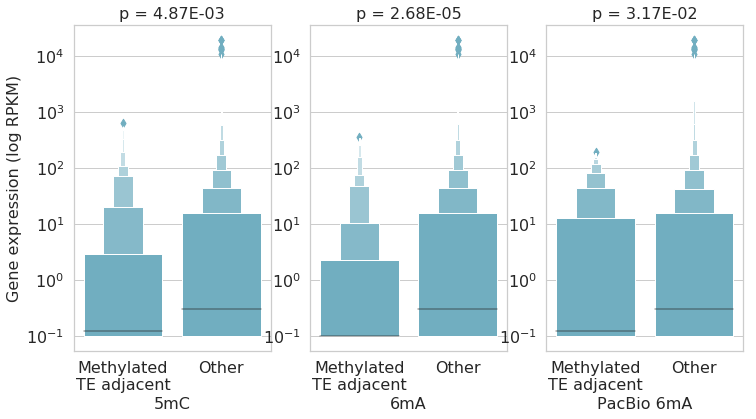

In [832]:
#make the actual graph for h contig
f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')


sns.boxenplot(y='UG_01', x='Top_5mC_Gene_TE', data=h_contig_df, order=order_2, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_xlabel('5mC', fontsize=16)
ax[0].set_title('p = 4.87E-03', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

sns.boxenplot(y='UG_01', x='Top_6mA_Gene_TE', data=h_contig_df, order=order_2, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('6mA', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 2.68E-05', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_6mA_pb_Gene_TE', data=h_contig_df, order=order_2, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('PacBio 6mA', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 3.17E-02', fontsize=16)


plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'gene_te_top_h.png'), bbox_inches='tight')

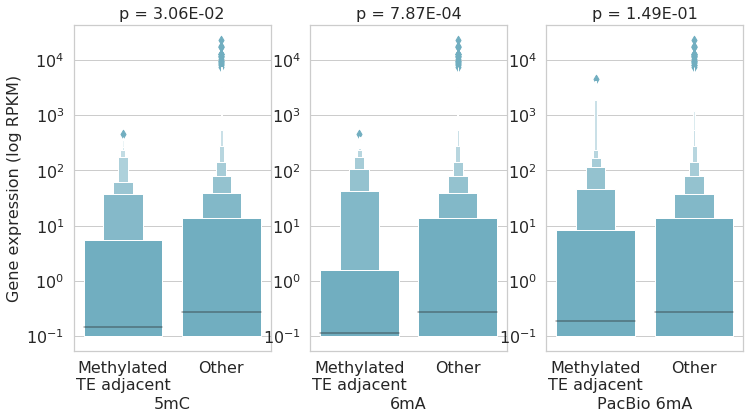

In [833]:
#make the actual graph for h contig
f, ax = plt.subplots(1, 3, figsize=(12,6))
plt.style.use('fast')


sns.boxenplot(y='UG_01', x='Top_5mC_Gene_TE', data=p_contig_df, order=order_2, ax=ax[0], color='c')
ax[0].set_yscale("log")
ax[0].set_ylabel('Gene expression (log RPKM)', fontsize=16)
ax[0].set_xlabel('5mC', fontsize=16)
ax[0].set_title('p = 3.06E-02', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

sns.boxenplot(y='UG_01', x='Top_6mA_Gene_TE', data=p_contig_df, order=order_2, ax=ax[1], color='c')
ax[1].set_yscale("log")
ax[1].set_xlabel('6mA', fontsize=16)
ax[1].set_ylabel(' ', fontsize=16)
ax[1].set_title('p = 7.87E-04', fontsize=16)

sns.boxenplot(y='UG_01', x='Top_6mA_pb_Gene_TE', data=p_contig_df, order=order_2, ax=ax[2], color='c')
ax[2].set_yscale("log")
ax[2].set_xlabel('PacBio 6mA', fontsize=16)
ax[2].set_ylabel(' ', fontsize=16)
ax[2].set_title('p = 1.49E-01', fontsize=16)


plt.savefig(os.path.join(DIRS['FIGURES'], 'expression', 'gene_te_top_p.png'), bbox_inches='tight')